In [183]:
%run Make_Question_simplified.ipynb
import numpy as np
from collections import defaultdict

import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import csv

SyntaxError: invalid syntax (<ipython-input-183-ccc0d9016b27>, line 1)

SyntaxError: invalid syntax (<ipython-input-183-ccc0d9016b27>, line 1)

In [186]:
N = 2
#M = 5
I = 2
J = 2
K = 3
Data_upperbound = 20
Processing_upperbound = 20
Data_input = Data_Queue(I,J,Data_upperbound)
Data_input_type = Data_Queue_type(I,J,K)
VM_type = VM_Data_type_gen(I,K,N)

VM_speed = VM_Data_processing_speed(Processing_upperbound, VM_type, K)
VM_DP_time = VM_Data_processing_time(Data_input, Data_input_type , VM_speed)

modified_VM_DP_time =np.copy(VM_DP_time)
modified_VM_DP_time[np.isinf(modified_VM_DP_time)]=np.inf

T_max = little_greedy_algorithm(VM_DP_time,I,J,N)

In [188]:
print(VM_type)
print(Data_input_type)
print(VM_DP_time)
print(np.min(VM_DP_time.reshape(I*J,N),1))
print("T_max is ",T_max)
print("let t = 1 unit of time")

[[1 2]
 [1 3]]
[[3 1]
 [3 1]]
[[[inf  5.]
  [ 1.  1.]]

 [[inf  5.]
  [ 1.  1.]]]
[5. 1. 5. 1.]
T_max is  12
let t = 1 unit of time


In [162]:
position_dictionary, Total = Make_dictionary(I,J,N,T_max)
QUBO_init = np.zeros((Total, Total))
P = {
    "Obj": 1,
    "C1":  1,
    "C2":  10,
    "C3":  1,
    "C4":  1,
    "C5":  1,
    "C6":  1,
    "C7":  1,
    "C8":  1,
    "C9":  1,
    "Cadd":  100,
    "Cadd1":  1,
    "Cadd2":  1,
}

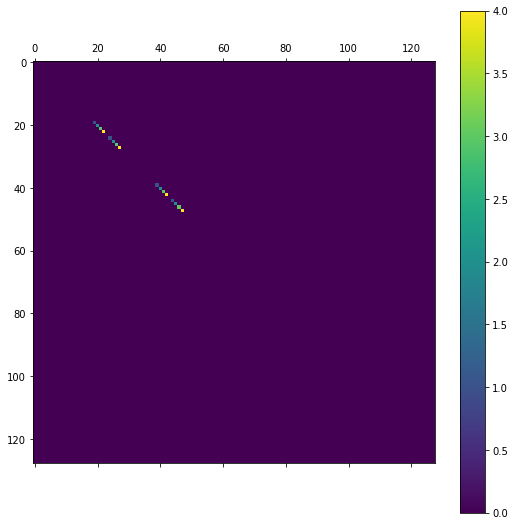

In [163]:
#Obj QUBO dont flatten yet
QUBO_0 = np.zeros_like(QUBO_init)
for i in range(I):    
    for m in range(N):
        for t in range(T_max):
            #print(position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)])
            index_matched = position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)]
            QUBO_0[index_matched,index_matched] += t

#print(QUBO)
show_graph(QUBO_0)

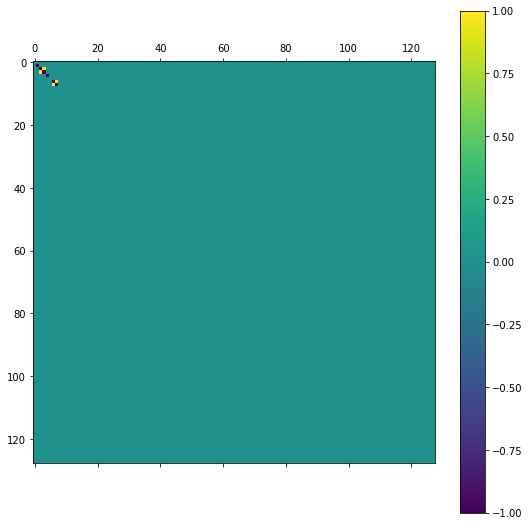

In [164]:
#C1 line(3)
P1 = np.ones((I,J)) * P["C1"]
QUBO_1 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J):
        
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        index_matched = [];
        
        for machine in V_ij_k:
            index_matched.append(position_dictionary['x_%d%d%d'%(i,j,machine)])
        
        #print(V_ij_k)
        x_matched = np.zeros(Total)
        x_matched[np.array(index_matched)] = 1
        QUBO_1 += P1[i,j]* (1 * np.outer(x_matched,x_matched) - 2*np.diag(x_matched))

show_graph(QUBO_1)

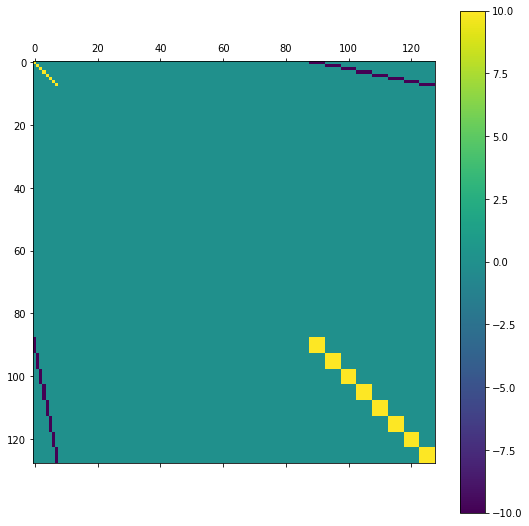

In [165]:
#C2 line(4)
P2 = np.ones((I,J,N)) * P["C2"]
QUBO_2 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            
            index_matched_z = []
            index_matched_x = []
            
            index_matched_x.append(position_dictionary['x_%d%d%d'%(i,j,m)])
            
            for t in range(T_max):
                index_matched_z.append(position_dictionary['z_%d%d%d%d'%(i,j,m,t)])
            #print(index_matched)
            var_matched = np.zeros(Total)
            var_matched[np.array(index_matched_z)] = -1
            var_matched[np.array(index_matched_x)] = 1
            QUBO_2 += P2[i,j,m]*np.outer(var_matched,var_matched)

show_graph(QUBO_2)

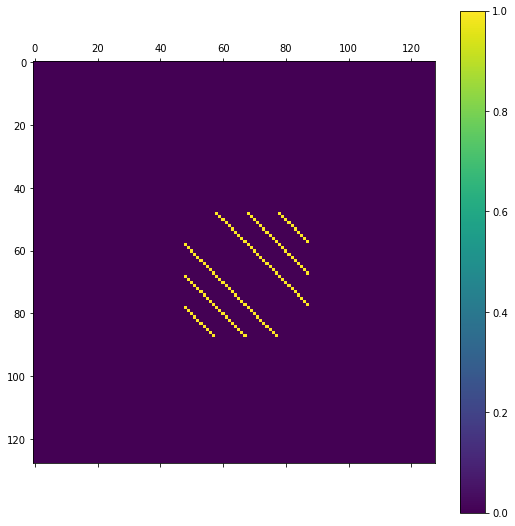

In [166]:
#C3 line(5)
P3 = np.ones((N,T_max)) * P["C3"]
QUBO_3 = np.zeros_like(QUBO_init)
for m in range(N):
    for t in range(T_max):
        index_matched = [];
        for i in range(I):
            for j in range(J):
                index_matched.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
        #print(index_matched)
        var_matched = np.zeros(Total)
        var_matched[np.array(index_matched)] = 1
        QUBO_3 += P3[m,t]*(np.outer(var_matched,var_matched)-np.diag(var_matched))

show_graph(QUBO_3)

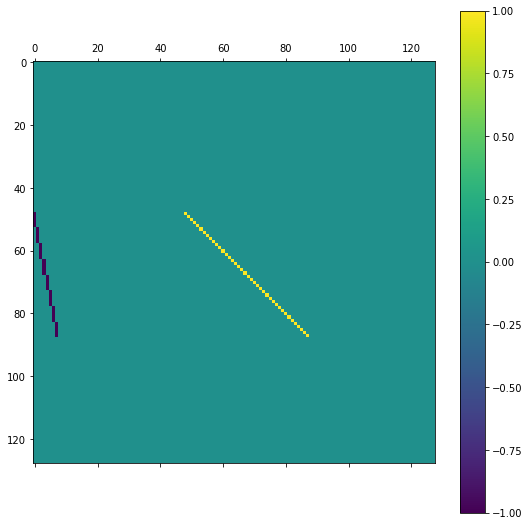

In [167]:
#C4 line(6)
P4 = np.ones((I,J,N,T_max)) * P["C4"]
QUBO_4 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                QUBO_temp = np.zeros_like(QUBO_init)
                index_matched_x = position_dictionary['x_%d%d%d'%(i,j,m)]
            
                index_matched_y = position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                #print(index_matched)
                QUBO_temp[index_matched_y,index_matched_y] = 1 
                QUBO_temp[index_matched_y,index_matched_x] = -1 
                QUBO_4 += P4[i,j,m,t]*QUBO_temp

show_graph(QUBO_4)

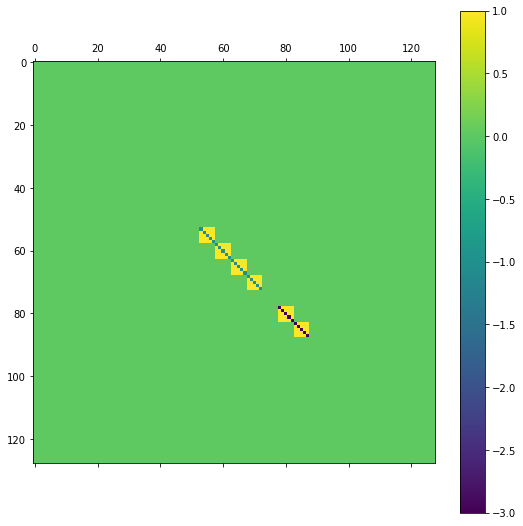

In [168]:
#C5 line(7)
P5 = np.ones((I,J,N)) * P["C5"]
QUBO_5 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        for machine in V_ij_k:
            index_matched_y = []
            for t in range(T_max):
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,machine,t)])
                
            var_matched = np.zeros(Total)
            #print(modified_VM_DP_time[i,j,m] )
            #print(index_matched_y)
            var_matched[np.array(index_matched_y)] = 1
            QUBO_5 += P5[i,j,machine]*( np.outer(var_matched,var_matched) - 2 * modified_VM_DP_time[i,j,machine] * np.diag(var_matched))


show_graph(QUBO_5)

In [169]:
print(modified_VM_DP_time) 

[[[inf  1.]
  [ 1.  1.]]

 [[ 1. inf]
  [ 2.  2.]]]


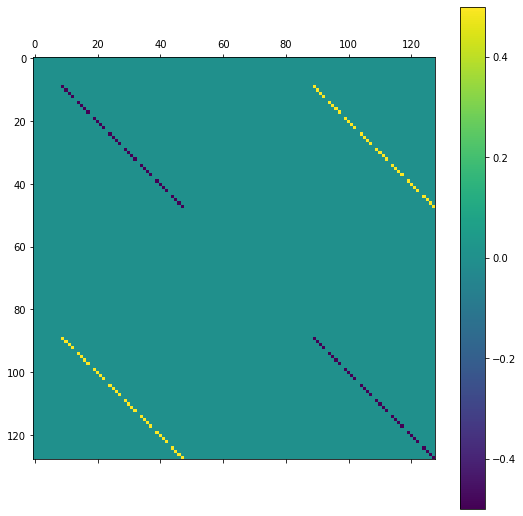

In [170]:
#C6 line(8)
P6 = np.ones((I,J,N,T_max)) * P["C6"]
QUBO_6 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(1,T_max):
                index_matched_z =  position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                index_matched_p =  position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                
                var_matched = np.zeros(Total)

                var_matched[index_matched_z ] = 1
                var_matched[index_matched_p ] = 1
                
                QUBO_6 += P6[i,j,m,t]*(0.5*np.outer(var_matched,var_matched)-np.diag(var_matched))


show_graph(QUBO_6)

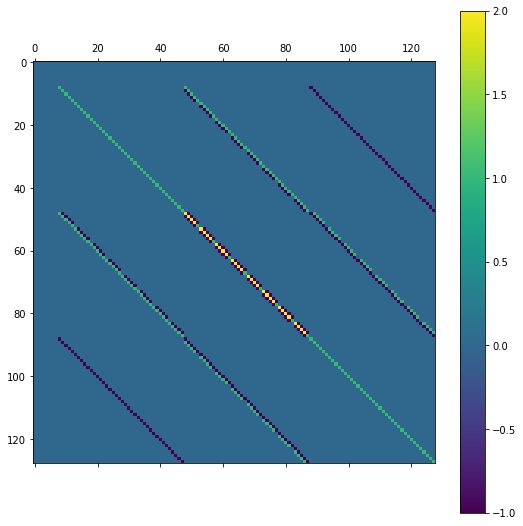

In [171]:
#C7 line(9)
P7 = np.ones((I,J,N,T_max)) * P["C7"]
QUBO_7 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                if t>0:
                    index_matched_y_pre =  position_dictionary['y_%d%d%d%d'%(i,j,m,t-1)]
                index_matched_y =  position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                index_matched_z =  position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                index_matched_p =  position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                
                var_matched = np.zeros(Total)
                
                if t>0:
                    var_matched[index_matched_y_pre] = 1
                var_matched[index_matched_y] = -1
                var_matched[index_matched_z ] = 1
                var_matched[index_matched_p ] = -1
                
                QUBO_7 += P7[i,j,m,t]*np.outer(var_matched,var_matched)
                #show_graph(np.outer(var_matched,var_matched))
                    
show_graph(QUBO_7)
                

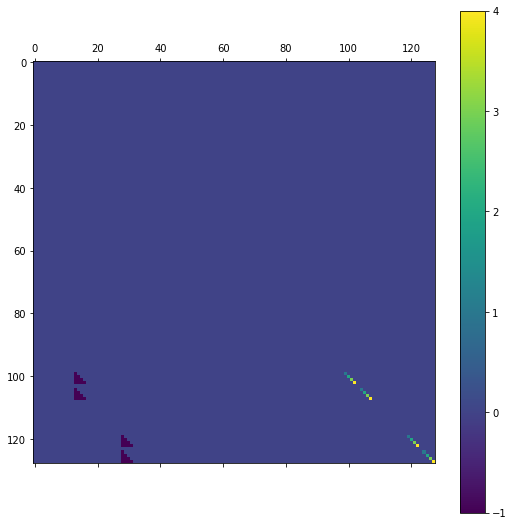

In [172]:
#C8 line(11)
P8 = np.ones((I,J,N,T_max,T_max)) * P["C8"]
QUBO_8 = np.zeros_like(QUBO_init)
beta = T_max

for i in range(I):
    for j in range(J-1):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        for machine in V_ij_k:
            for t in range(T_max):
                for beta in range(1,T_max+1):
                    
                    V_ijplus1_k, _ = np.where(VM_type == Data_input_type[i,j+1])
                    
                    t_prime = t + beta 
                    
                    if (t_prime >= T_max) or (t_prime <= 0):
                        
                        continue                                            
                    
                    for machine_prime in V_ijplus1_k:
                        
                        QUBO_temp = np.zeros_like(QUBO_init)    
                    
                        index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j+1,machine_prime,t_prime)]
                        
                        index_matched_p = position_dictionary['p_%d%d%d%d'%(i,j,machine,t)]
                        #print(index_matched)
                        QUBO_temp[index_matched_z,index_matched_z] = 1 
                        QUBO_temp[index_matched_z,index_matched_p] = -1 
                        QUBO_8 += P8[i,j,machine,t,t_prime] * QUBO_temp

show_graph(QUBO_8)

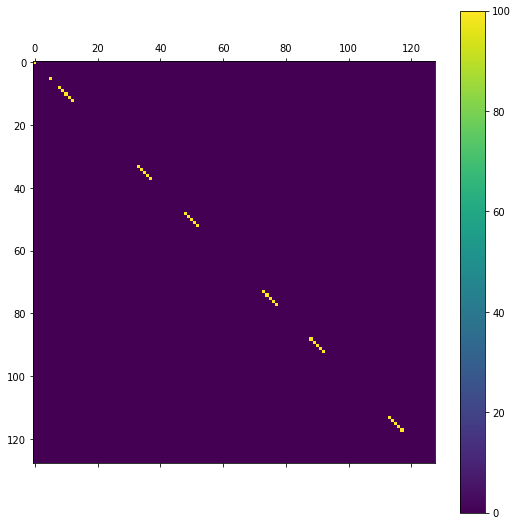

In [173]:
#C add line(##)
P_add = P["Cadd"]
QUBO_add = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        
        All_VM = np.arange(N)
        diff_VM = np.setdiff1d(All_VM,V_ij_k)
        #print(V_ij_k)
        #print(diff_VM )
        for machine in diff_VM :
            index_matched_x = position_dictionary['x_%d%d%d'%(i,j,machine)]
            QUBO_add[index_matched_x,index_matched_x] = P_add
            for t in range(T_max):
                index_matched_p = position_dictionary['p_%d%d%d%d'%(i,j,machine,t)]
                index_matched_y = position_dictionary['y_%d%d%d%d'%(i,j,machine,t)]
                index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j,machine,t)]
                QUBO_add[index_matched_p,index_matched_p] = P_add
                QUBO_add[index_matched_y,index_matched_y] = P_add
                QUBO_add[index_matched_z,index_matched_z] = P_add
                
                
               
show_graph(QUBO_add)

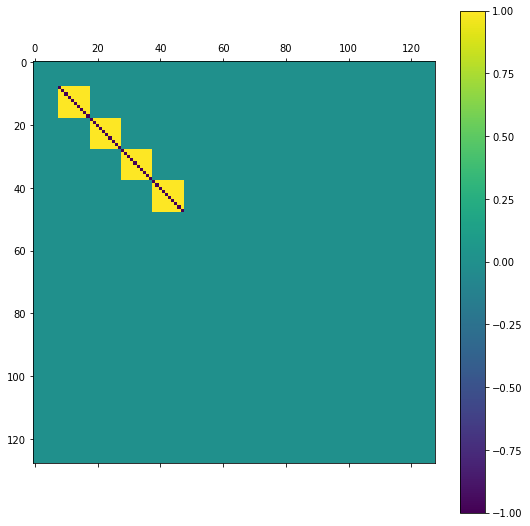

In [174]:
#C_add1 line(3) about p
P_add_1 = np.ones((I,J,N)) * P["Cadd1"]
QUBO_add_1 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J):
        index_matched = [];
        for m in range(N):
            for t in range(T_max):
                index_matched.append(position_dictionary['p_%d%d%d%d'%(i,j,m,t)])
            p_matched = np.zeros(Total)
            p_matched[np.array(index_matched)] = 1
        QUBO_add_1 += P_add_1[i,j,m]* (1 * np.outer(p_matched, p_matched) - 2*np.diag(p_matched))

show_graph(QUBO_add_1)

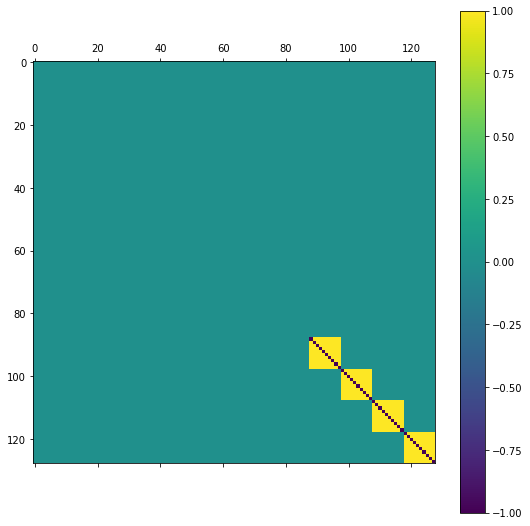

In [175]:
#C_add1 line(3) about z
P_add_2 = np.ones((I,J,N)) * P["Cadd2"]
QUBO_add_2 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J):
        index_matched = [];
        for m in range(N):
            for t in range(T_max):
                index_matched.append(position_dictionary['z_%d%d%d%d'%(i,j,m,t)])
            p_matched = np.zeros(Total)
            p_matched[np.array(index_matched)] = 1
        QUBO_add_2 += P_add_2[i,j,m]* (1 * np.outer(p_matched, p_matched) - 2*np.diag(p_matched))

show_graph(QUBO_add_2)

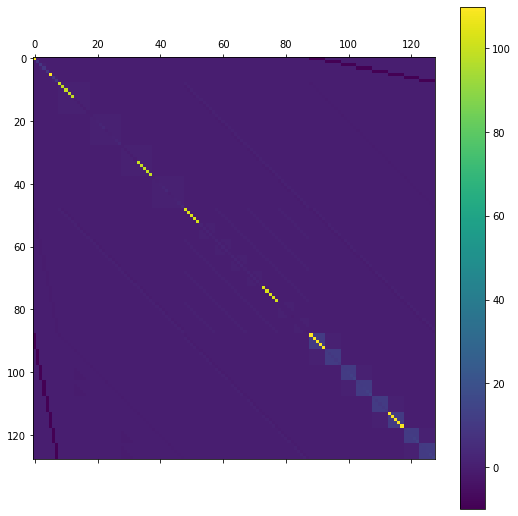

In [176]:
QUBO = np.zeros_like(QUBO_init)
QUBO = QUBO_0 * P['Obj'] + QUBO_add + QUBO_1 + QUBO_2 + QUBO_3 + QUBO_4 + QUBO_5 + QUBO_6 + QUBO_7 + QUBO_8 + QUBO_add_1 + QUBO_add_2
show_graph(QUBO) 

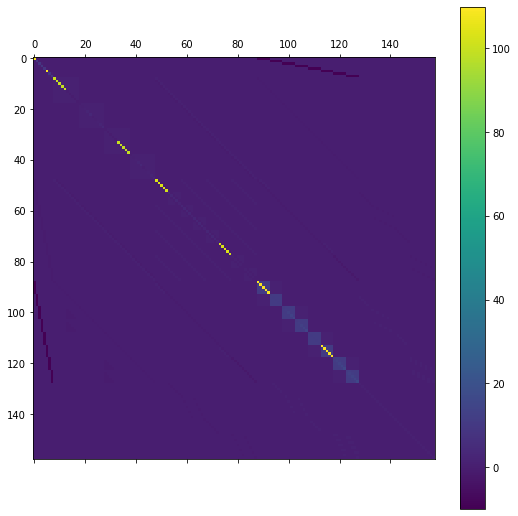

In [178]:
## Single Slack Variable part
#C9 line(10)

constraint = 9
P9 = np.ones((I,J,N,T_max)) * P["C9"]
for i in range(I):
    for j in range(J):
        for t in range(T_max):
            V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
            for machine in V_ij_k:
            
                index_matched_y = []
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,machine,t)])                
                
                alpha = 0
                index_matched_z = []
                for alpha in range(int(modified_VM_DP_time[i,j,machine])):
                    t_prime = t-alpha+1
                    if (t_prime >= 0) and (t_prime < T_max):
                        index_matched_z.append( position_dictionary['z_%d%d%d%d'%(i,j,machine,t_prime)] ) 
                    else:
                        continue
                        
                
                #slack var
                #print(index_matched_z,index_matched_y)

    
                position_dictionary["s_%d_%d%d%d%d"%(constraint,i,j,machine,t)] = Total
                Total += 1
                
                QUBO = np.pad(QUBO, [(0, 1), (0, 1)], mode='constant', constant_values = 0)
                #print(np.shape(QUBO))
                #
                
                #print(len(position_dictionary))
                var_matched = np.zeros(Total)
                var_matched[index_matched_y] = -1
                var_matched[index_matched_z] = 1
                var_matched[-1] = 1
                QUBO += P9[i,j,machine,t]*np.outer(var_matched,var_matched)
                #show_graph(np.outer(var_matched,var_matched)) 
show_graph(QUBO) 

In [179]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import numpy as np
import dwave.inspector
import dimod

import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt

In [180]:
c = 1
width,height = np.shape(QUBO)

QUBO_dictionary = defaultdict(int)
for i in range(width):
    for j in range(height):
        QUBO_dictionary[(i,j)] = QUBO[i,j]
import dwave.inspector
sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))

num_reads = 10000
#sampleset = sampler.sample_qubo(QUBO, chain_strength = 8, num_reads=num_reads)
sampleset = sampler.sample_qubo(QUBO, num_reads=num_reads)

In [181]:
#print(sampleset)

In [182]:
#sample = sampleset.first.sample
#energy = sampleset.first.energy
#print(sample,energy)
OP = sampleset.to_pandas_dataframe()
import pandas as pd
OP = OP.sort_values("energy")
OP_final = OP.to_numpy()

rank = 0

OP_opt = OP_final[rank,:].flatten()
sample = OP_opt.astype(int)


#dir(sampleset)
print("Constraint_1: ",check_C1 (position_dictionary,sample,I,J,VM_type,Data_input_type))
print("Constraint_2: ",check_C2 (position_dictionary,sample,I,J,N,T_max))
print("Constraint_3: ",check_C3 (position_dictionary,sample,I,J,N,T_max))
print("Constraint_4: ",check_C4 (position_dictionary,sample,I,J,N,T_max))
print("Constraint_5: ",check_C5 (position_dictionary,sample,I,J,VM_type,Data_input_type,T_max,modified_VM_DP_time))
print("Constraint_6: ",check_C6 (position_dictionary,sample,I,J,N,T_max))
print("Constraint_7: ",check_C7 (position_dictionary,sample,I,J,N,T_max))
print("Constraint_8: ",check_C8 (position_dictionary,sample,I,J,VM_type,Data_input_type,T_max,modified_VM_DP_time))
print("Constraint_9: ",check_C9 (position_dictionary,sample,I,J,VM_type,Data_input_type,T_max))
print("Constraint_add: ",check_C_add(position_dictionary,sample,I,J,N,VM_type,Data_input_type,T_max))
print("Constraint_add_p: ",check_C_add_1(position_dictionary,sample,I,J,N,T_max))
print("Constraint_add_z: ",check_C_add_2(position_dictionary,sample,I,J,N,T_max))

Constraint_1:  True
Constraint_2:  True
Constraint_3:  False
Constraint_4:  False
Constraint_5:  False
Constraint_6:  False
Constraint_7:  False
Constraint_8:  False
Constraint_9:  False
Constraint_add:  True
Constraint_add_p:  False
Constraint_add_z:  False


In [89]:
#sample = np.fromiter(sample.values(), dtype=int)
#sample
#OP

In [90]:
np.save('Answers/Data_input', Data_input)
np.save('Answers/Data_input_type ', Data_input_type )
np.save('Answers/VM_type', VM_type)
np.save('Answers/VM_speed', VM_speed)
np.save('Answers/answer', sample)

In [142]:
opt_time = 0
for i in range(I):    
    for m in range(N):
        for t in range(T_max):
            print('p_%d%d%d%d value:'%(i,J-1,m,t), sample[position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)]])
            
            opt_time += t * sample[position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)]]
            

print("The opt_time is: ", opt_time)
print("the greedy time is: ", T_max)


p_0100 value: 0
p_0101 value: 0
p_0102 value: 0
p_0103 value: 0
p_0104 value: 0
p_0105 value: 1
p_0106 value: 0
p_0110 value: 0
p_0111 value: 0
p_0112 value: 0
p_0113 value: 0
p_0114 value: 0
p_0115 value: 0
p_0116 value: 0
p_1100 value: 0
p_1101 value: 0
p_1102 value: 0
p_1103 value: 0
p_1104 value: 0
p_1105 value: 0
p_1106 value: 0
p_1110 value: 0
p_1111 value: 0
p_1112 value: 1
p_1113 value: 0
p_1114 value: 1
p_1115 value: 0
p_1116 value: 0
The opt_time is:  11
the greedy time is:  7


In [143]:
opt_time = 0
for i in range(I): 
    for j in range(J): 
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        for machine in V_ij_k:
            print(i,j,machine,'x_%d%d%d'%(i,j,machine),)
            #print('x_%d%d%d value:'%(i,j,m,t), sample[position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)]])
            opt_time += VM_DP_time[i,j,machine] * sample[position_dictionary['x_%d%d%d'%(i,j,machine)]]
            

print("The opt_time is: ", opt_time)
print("the greedy time is: ", T_max)

0 0 1 x_001
0 1 0 x_010
1 0 0 x_100
1 0 1 x_101
1 1 1 x_111
The opt_time is:  13.0
the greedy time is:  7


In [86]:
#print(sampleset)

In [131]:
#position_dictionary

In [136]:
#keys=sample[:I*J*N]
#answer = keys.reshape([I,J,N])
#print(answer)

In [49]:
np.empty([0])

array([], dtype=float64)

In [ ]:
OP = sampleset.to_pandas_dataframe()
OP

,0,1,2,3,4,5,6,7,8,9,...,338,339,340,341,342,343,344,chain_break_fraction,energy,num_occurrences
0,1,0,0,1,0,1,1,1,0,1,...,1,0,1,1,0,0,0,0.028986,8318.0,1
1,1,0,0,1,0,1,1,1,0,1,...,1,0,1,0,0,0,0,0.020290,10229.0,1
2,1,0,1,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0.031884,12144.0,1
3,1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0.023188,9629.0,1
4,1,0,1,0,0,0,0,1,0,1,...,0,0,1,1,0,1,0,0.026087,9729.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,1,0,0,1,1,1,1,...,0,0,0,1,0,0,0,0.066667,20949.0,1
9996,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,0,0,0,0.063768,16854.0,1
9997,1,0,1,1,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0.063768,16534.0,1
9998,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0.057971,17140.0,1


In [137]:
import pandas as pd

In [138]:
OP = OP.sort_values("energy")
OP

,0,1,2,3,4,5,6,7,8,9,...,338,339,340,341,342,343,344,chain_break_fraction,energy,num_occurrences
1108,1,0,0,1,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0.034783,6721.0,1
3624,1,0,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0.046377,6827.0,1
3742,1,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0.037681,6936.0,1
134,1,0,1,0,0,1,1,1,0,1,...,0,0,0,0,1,0,0,0.014493,7027.0,1
26,1,0,0,1,0,1,0,1,0,1,...,1,0,0,0,0,0,1,0.023188,7030.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7705,1,0,1,1,0,1,1,1,1,1,...,0,1,1,1,0,0,1,0.028986,22228.0,1
9975,1,0,1,0,1,1,0,0,0,1,...,0,0,1,0,0,1,0,0.057971,22334.0,1
9972,1,0,0,1,0,1,1,1,1,1,...,0,0,1,0,0,0,0,0.052174,22343.0,1
9599,1,0,1,0,0,1,1,1,0,0,...,1,0,1,0,0,1,0,0.043478,22635.0,1


In [139]:
#OP = OP.sort_values("num_occurrences")
#OP

In [140]:
OP_final = OP.to_numpy()

In [146]:
OP_opt = OP_final[0,:].flatten()

In [147]:
op_opt = OP_opt.astype(int)

In [148]:
op_opt[0]

1

In [149]:
keys = op_opt[:I*J*N]
print(keys)
answer = keys.reshape([I,J,N])

print(answer)

[1 0 0 1 0 1 1 0]
[[[1 0]
  [0 1]]

 [[0 1]
  [1 0]]]


In [150]:
print(VM_type)

[[2 3]
 [1 3]]


In [151]:
print(Data_input_type)

[[2 3]
 [1 3]]


In [ ]:
#from dwave.system import LeapHybridSampler
'''
import hybrid
workflow = hybrid.Loop(
   hybrid.RacingBranches(
      hybrid.InterruptableTabuSampler(),
      hybrid.EnergyImpactDecomposer(size=30, rolling=True, rolling_history=0.75)
      | hybrid.QPUSubproblemAutoEmbeddingSampler()
      | hybrid.SplatComposer()) | hybrid.ArgMin(), convergence=3)
bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
result = hybrid.HybridSampler(workflow).sample(bqm)  
'''
#print("Solution: sample={}".format(result.first)) 

c = 1

# Select a solver
#sampler = LeapHybridSampler()



# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
#chainstrength = 8
#numruns = 3  #Max =1e4 , a Complex problem needs more numruns 

#response = sampler.sample_qubo(QUBO)


#dwave_sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
#bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
#sampleset = dwave_sampler.sample(bqm, num_reads=1000)



#sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6'))
#response = sampler.sample_qubo(QUBO_dictionary, chain_strength=chainstrength, num_reads=numruns)
